### Overview
This notebook works on the IEEE-CIS Fraud Detection competition. Here I build a simple XGBoost model based on a balanced dataset.

In [1]:
# all imports necessary for this notebook
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# read data
folder_path = '../input/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv')
# Merge identity and transaction data 
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

del train_identity, train_transaction, test_identity, test_transaction

In [3]:
# Encode categorical variables
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 
            'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 
            'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 
            'card6', 'M4','P_emaildomain',  'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 
            'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

for col in cat_cols:
    train_df[col] = train_df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes

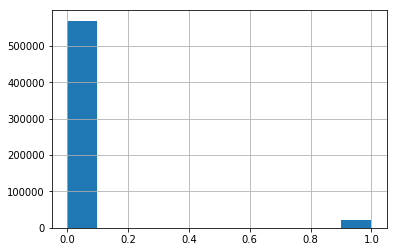

In [4]:
train_df['isFraud'].hist()

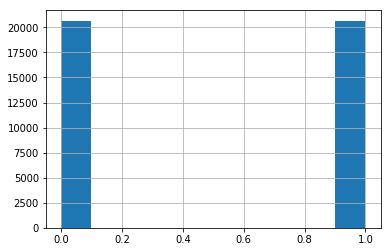

In [5]:
#### First identify variables' importance using XGBoost on a balanced dataset
length_ones = len(train_df[train_df['isFraud']==1])
train_balanced = pd.concat([train_df[train_df['isFraud']==1], (train_df[train_df['isFraud']==0]).sample(length_ones)], axis=0)
train_balanced['isFraud'].hist()

In [6]:
# Build and validate the XGBoost model
X_train, X_test, y_train, y_test = train_test_split(
    train_balanced.drop(columns=['isFraud']), train_balanced['isFraud'], test_size=1/3, random_state=0)
print(X_train.shape)
print(X_test.shape)

clf = XGBClassifier(max_depth = 40)
clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)
pred_prob[:, 1]
print(roc_auc_score(y_test, pred_prob[:, 1]))

(27550, 433)
(13776, 433)
0.9479226238428692


In [7]:
# Test the model on all training data (except for what's been used to build the model)
temp_df = pd.concat([train_df.drop(columns=['isFraud']), X_train]).drop_duplicates(keep=False)
pred_prob = clf.predict_proba(temp_df)
temp_df = temp_df.merge(train_df[['TransactionID', 'isFraud']], on='TransactionID', how='left', validate = "one_to_one")
if temp_df.shape[0] + X_train.shape[0] != train_df.shape[0]:
    print("Error!!!")
print(roc_auc_score(temp_df['isFraud'], pred_prob[:, 1]))

0.9481167717618004


In [8]:
# Re-train the model based on all data in the balanced dataset
clf.fit(train_balanced.drop(columns=['isFraud']), train_balanced['isFraud'])
# Test again, this time on all training data without any exclusion
pred_prob = clf.predict_proba(train_df.drop(columns=['isFraud']))
print(roc_auc_score(train_df['isFraud'], pred_prob[:, 1]))

0.9956535535840789


In [9]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [10]:
# prepare submission
pred_prob = clf.predict_proba(test_df)
submission = pd.DataFrame(test_df['TransactionID'].copy())
submission['isFraud'] = pred_prob[:, 1]
submission.iloc[np.r_[:4, -4:]]

,TransactionID,isFraud
0,3663549,0.025550
1,3663550,0.028071
2,3663551,0.029110
3,3663552,0.031371


In [11]:
submission.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 